<a href="https://colab.research.google.com/github/gcobc26744/AI-notes/blob/main/MNIST_NCU_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEMO1 CNN Classification

* 資料集: [MNIST](http://yann.lecun.com/exdb/mnist/)
* 參考 : https://keras.io/examples/vision/mnist_convnet/

深度學習在訓練模型上有以下幾個重要的步驟:
1. 讀入相關封包
2. 取得資料集
3. 資料前處理
4. 建立模型
5. 制定訓練計畫
6. 評估模型

根據以上步驟，我們來訓練一個簡單的手寫數字辨識模型

## 1. 讀入封包

深度學習一般目前市場上常見的有tensorflow、keras、pytorch。本次Demo使用keras，keras是一個簡單好用的模型訓練工具。能夠幫助初學者省去很多在訓練上的細節，使機器學習更加快速、好上手。

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt

## 2. 取得資料集

* 由keras內部method可以線上取得MNIST的資料集。並且已經自動分離出了訓練用與測試用的資料集。
* x_train是一個包含60000張圖片，每一張圖片為28X28的手寫灰階圖片。(灰階圖片指圖片沒有RGB通道，每一個pixel為0\~255 白\~黑)
* x_train要預測的是y_train的60000個對應標籤，分別是當前對應圖片的0~9數字。因此共十個class。

In [ ]:
num_classes = 10

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print("x_train shape : ",x_train.shape)
print("y_train shape : ",y_train.shape)
print("-"*20)
print("x_test shape : ",x_test.shape)
print("y_test shape : ",y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
x_train shape :  (60000, 28, 28)
y_train shape :  (60000,)
--------------------
x_test shape :  (10000, 28, 28)
y_test shape :  (10000,)


* 我們可以實際將這些圖片印出來看看

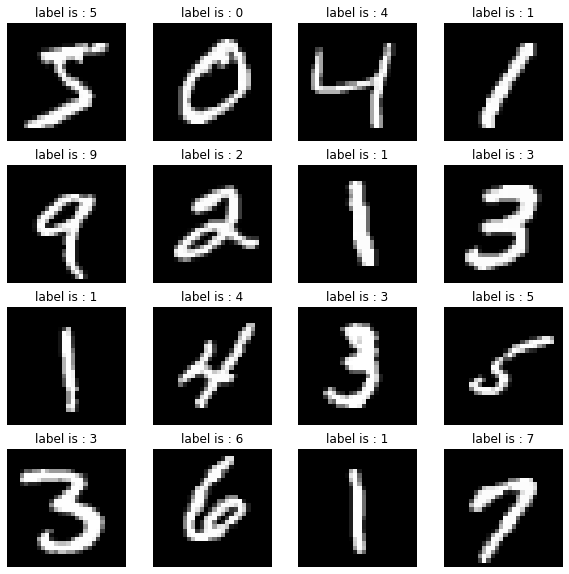

In [ ]:
# 印出來看看
plt.figure(figsize=(10, 10))
for i in range(16):
    img = x_train[i]
    plt.subplot(4,4,i+1)
    plt.imshow(img,cmap ='gray')
    plt.title("label is : {}".format(y_train[i]))
    plt.axis("off")

## 3. 資料前處理

* 可以知道一張圖片的維度是(28,28)，但是實際輸入模型的維度是(28,28,1)。灰階圖片少了channel，所以我們要拓展維度 (作為channel)

* 然後我們要把圖片pixel 自 [0,255] --> [0,1] ，讓深度學習在矩陣相乘時不會因為數值相乘太大而很難訓練。

In [ ]:
# expand dim
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("x_train shape : ",x_train.shape)
print("x_test shape : ",x_test.shape)

# scale the range
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255

x_train shape :  (60000, 28, 28, 1)
x_test shape :  (10000, 28, 28, 1)


- 然後要把label轉為one-hot。因為我們預期模型訓練是
    - 輸入: (28,28,1) 的圖片
    - 輸出: (10,) 的機率
    
    
- 打個比方:
    - ![](https://i.imgur.com/aCYEeRB.png)
    - 所以我們需要將label轉成one-hot 格式

In [ ]:
train_label = keras.utils.to_categorical(y_train, num_classes)
test_label = keras.utils.to_categorical(y_test, num_classes)

for i in range(10):
    print(y_train[i]," ---> ",train_label[i])

5  --->  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0  --->  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4  --->  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
1  --->  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
9  --->  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
2  --->  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
1  --->  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
3  --->  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
1  --->  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
4  --->  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


## 4. 建立模型

我們本次建立的模型CNN，由Convolution層與Fully Connection層組成

#### **對Keras來說**

1. 一張圖片通過**Conv**後維度計算: [keras Conv](https://keras.io/api/layers/convolution_layers/convolution2d/)
* 默認stride:(1,1)
* 默認padding = None
* Input: $(N,H_{in},W_{in},C_{in})$
* Output: $(N,H_{out},W_{out},C_{out})$
* $H_{out} =\frac{[H_{in}+2*padding-kernal]}{stride} +1$
* $W_{out} =\frac{[W_{in}+2*padding-kernal]}{stride} +1$

> E.g.
>
> input: **(32,28,28,3)**
>
> kernel: 3,padding=0,stride=1,filters=32
>
> $(28-2*0-3)/1 + 1 = 26$
>
> output: **(32,26,26,32)**

2. 一張圖片通過**MaxPooling**後維度計算:[keras MaxPooling](https://keras.io/api/layers/pooling_layers/max_pooling2d/)
* 默認pooing_size:(2,2)
* 默認padding : None
* 默認stride : pooling_size
* Input: $(N,H_{in},W_{in},C_{in})$
* Output: $(N,H_{out},W_{out},C_{out})$
* $H_{out} =\frac{[H_{in}+2*padding-poolingKernel]}{stride} +1$
* $W_{out} =\frac{[W_{in}+2*padding-poolingKernel]}{stride} +1$

> E.g.
>
> input: **(32,26,26,32)**
>
> kernel:2,padding=0,stride=2
>
> $(26-2*0-2)/2 + 1 = 13$
>
> output: **(32,13,13,32)**

![](https://i.imgur.com/x6rG5gb.png)

In [ ]:
input_shape = (28, 28, 1)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               819712    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)              

## 5. 制定訓練計畫

- 制定訓練計畫包含該如何進行訓練
    - batch_size : 因為神經網路其實只是矩陣相乘，我們可以擴大丟入模型的圖片數量，這個就是一次要丟入幾張圖片。
    - epochs : 總共要循環幾次所有訓練資料集來訓練模型
    - loss : 預測值與真實label之間的差距計算方式
    - optimizer : 運練更新模型的方法
    - metrics : keras 訓練過程中恆量模型的方法
    - validation dataset : 在一開始將training data部分資料剝離，所以模型完全不會偷看到validation data。這部分的資料用來在訓練過程中檢視模型的好壞。
    
- 訓練步驟
    - keras不需要你寫訓練步驟，你只要在model.fit把input資料與true label丟入即可

In [ ]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(x_train, train_label, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/15
375/375 [==============================] - 33s 11ms/step - loss: 0.5026 - accuracy: 0.8494 - val_loss: 0.0647 - val_accuracy: 0.9808
Epoch 2/15
375/375 [==============================] - 4s 10ms/step - loss: 0.0721 - accuracy: 0.9773 - val_loss: 0.0476 - val_accuracy: 0.9861
Epoch 3/15
375/375 [==============================] - 4s 10ms/step - loss: 0.0500 - accuracy: 0.9840 - val_loss: 0.0427 - val_accuracy: 0.9883
Epoch 4/15
375/375 [==============================] - 4s 10ms/step - loss: 0.0380 - accuracy: 0.9878 - val_loss: 0.0387 - val_accuracy: 0.9888
Epoch 5/15
375/375 [==============================] - 4s 10ms/step - loss: 0.0327 - accuracy: 0.9901 - val_loss: 0.0364 - val_accuracy: 0.9890
Epoch 6/15
375/375 [==============================] - 4s 10ms/step - loss: 0.0254 - accuracy: 0.9919 - val_loss: 0.0343 - val_accuracy: 0.9910
Epoch 7/15
375/375 [==============================] - 4s 10ms/step - loss: 0.0207 - accuracy: 0.9939 - val_loss: 0.0352 - val_accuracy: 0.990

## 6. 評估模型

- 查看訓練過程中的成果
    - val accuracy、 loss 與train data相比
    - 要是train acc比val acc大很多，train loss比val loss 小很多，則稱為overfitting。模型不夠泛化，太專注於看過的東西了。

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


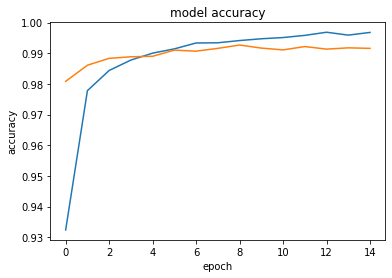

In [ ]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

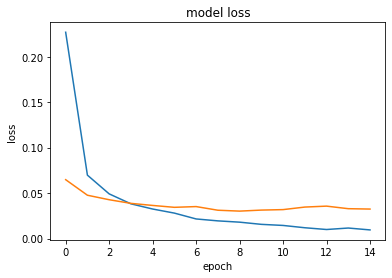

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

- **測試模型**
經過train、val data來調整完成模型後，用model完全沒看過的資料 test data來測試模型準確度

In [ ]:
score = model.evaluate(x_test, test_label, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.029757894575595856
Test accuracy: 0.9919999837875366
